### 1. Replace the implemented solution for corner detection with the more stable OpenCV provided method. Assess the quality of the features matching using the presented methods.


In [1]:
import time

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
from scipy.ndimage.filters import maximum_filter
from sklearn.decomposition import PCA

def extract_harris_response(in_img, sigma, k, thresh, min_distance):
  h, w = in_img.shape
  width = int(np.ceil(3 * sigma)) # 97% of the values are in [m-3s, m+3s]
  xx = np.vstack([np.arange(-width, width + 1, dtype=np.float32) for _ in range(2 * width + 1)])
  yy = xx.T
  gaussian_kern = 1/(2 * sigma**2) * (-(np.square(xx) + np.square(yy)))
  gaussian_kern = np.exp(gaussian_kern)

  # compute image gradients
  horizontal_filter = 1/2 * np.array([[0, 0, 0],
                                      [-1, 0, 1],
                                      [0, 0, 0]])
  vertical_filter = 1/2 * np.array([[0, -1, 0],
                                    [0, 0, 0],
                                    [0, 1, 0]])
  in_img_x = cv.filter2D(in_img, -1, horizontal_filter)
  in_img_y = cv.filter2D(in_img, -1, vertical_filter)


  img_x_sq = cv.filter2D(np.square(in_img_x), -1, gaussian_kern)
  img_y_sq = cv.filter2D(np.square(in_img_y), -1, gaussian_kern)
  img_xy = cv.filter2D(in_img_x * in_img_y, -1, gaussian_kern)
  # plt.imshow(img_xy)

  C = np.zeros((h, w))
  # keep indices for the corners
  corners = np.zeros((2, h * w))

  # compute the filter response for each of the image pixels
  for i in range(h):
    for j in range(w):
      H = np.array([[img_x_sq[i, j], img_xy[i, j]],
                    [img_xy[i, j], img_y_sq[i, j]]])
      filter_response = np.linalg.det(H) - k * (np.trace(H) ** 2)
      C[i, j] = filter_response

  # perform non_max suppression
  coordinates = peak_local_max(C, min_distance=min_distance)


  corner_idx = 0
  for i, j in coordinates:
    if C[i, j] > thresh * C.max():
        corners[:, corner_idx] = np.array([i, j])
        corner_idx += 1

  return C, corners[:, :corner_idx]

def extract_cv_response(gray, block_size, k_size, k, thresh, min_distance):
    dst = cv.cornerHarris(gray, block_size, k_size, k)
    dst = cv.dilate(dst,None)
    coordinates = peak_local_max(dst, min_distance=min_distance)

    corners = np.zeros((2, dst.shape[0] * dst.shape[1]))
    corner_idx = 0
    for i, j in coordinates:
        if dst[i, j] > thresh * dst.max():
            corners[:, corner_idx] = np.array([i, j])
            corner_idx += 1
    corners = corners[:, :corner_idx]
    return gray, corners


img = cv.imread("image001.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY).astype(np.float32)
h, w = gray.shape

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_22464\4260857112.py:7: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


37.915783643722534


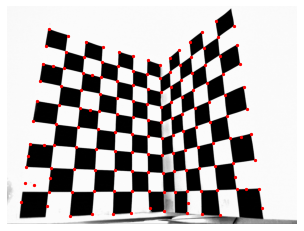

In [2]:
start = time.time()
C_1, corner_idx_1 = extract_harris_response(gray, 1, 4e-2, 1e-4, min_distance=45)
print(time.time() - start)
plt.axis('off')
plt.imshow(gray, cmap='gray')
for position in corner_idx_1.T:
  plt.scatter(position[1], position[0], s=5, c='red', marker='o')

0.24106645584106445


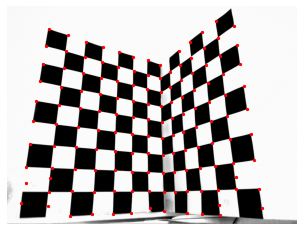

In [3]:
start = time.time()
C_2, corner_idx_2 = extract_cv_response(gray, 2, 3, 0.04, 1e-4, 45)
print(time.time() - start)
plt.axis('off')
plt.imshow(gray, cmap='gray')
for position in corner_idx_2.T:
  plt.scatter(position[1], position[0], s=5, c='red', marker='o')

There's no notable difference between using the more stable cv.cornerHaris response or not.
However, the computation time for cv.cornerHaris is far lower.

In [4]:
def filter_candidate_points(candidate, width, height):
  y, x = candidate # keep in mind the
  return 4 <= x < width - 4 and 4 <= y < height - 4

filtered_l1_candidates = np.array([x for x in corner_idx_1.T if filter_candidate_points(x, w, h)]).T
filtered_l2_candidates = np.array([x for x in corner_idx_2.T if filter_candidate_points(x, w, h)]).T

In [5]:

def feature_extractor(img, point):
  i, j = point.astype(np.int32)
  return img[(i-4):(i+5), (j-4):(j+5)].flatten()


l1_data = np.array([feature_extractor(gray, x) for x in filtered_l1_candidates.T])
l2_data = np.array([feature_extractor(gray, x) for x in filtered_l2_candidates.T])


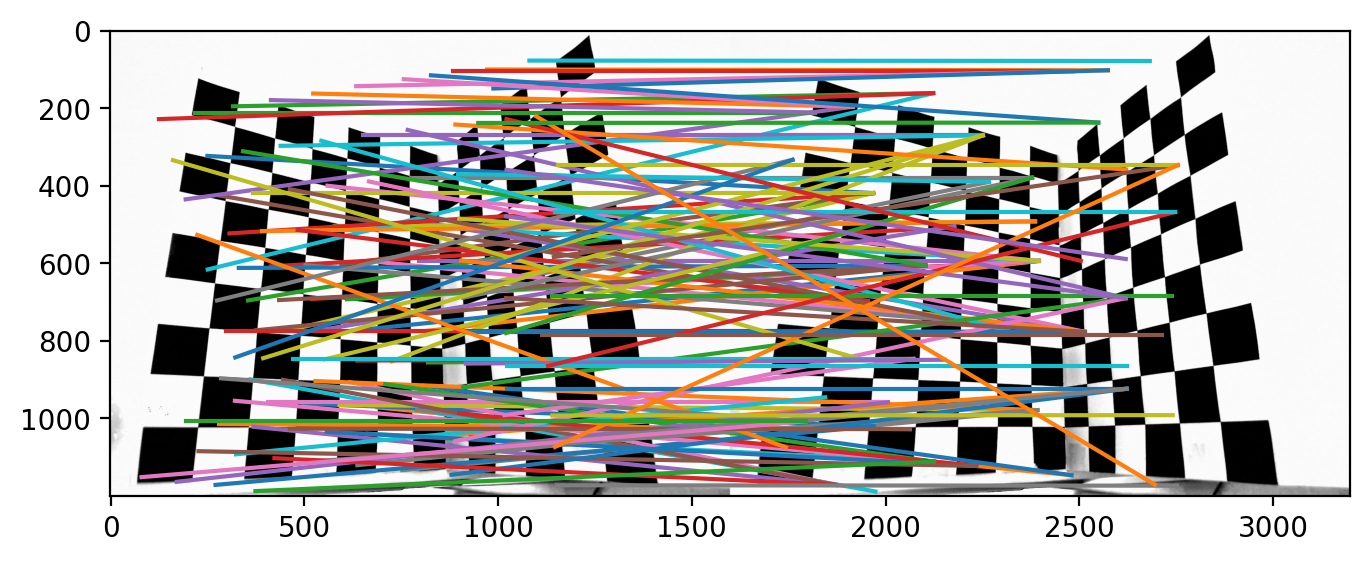

In [6]:
from sklearn.neighbors import KDTree


def plot_matches(img1, img2, matches):
  plt.rcParams['figure.figsize'] = [8, 4]
  plt.rcParams['figure.dpi'] = 200
  h, w = img1.shape
  result = np.zeros((h, 2 * w))
  result[:, :w] = img1
  result[:, w:] = img2
  plt.imshow(result, cmap='gray')
  for y1, x1, y2, x2 in matches.T:
    xs = [x1, x2 + w]
    ys = [y1, y2]
    if filter_candidate_points([y1, x1], w, h) == True \
     and filter_candidate_points([y2, x2 + w],  2* w, h) == True:
      plt.plot(xs, ys)


l1_kdt = KDTree(l1_data, leaf_size=5, metric='euclidean')
l2_kdt = KDTree(l2_data, leaf_size=5, metric='euclidean')

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, the nearest neighbor in the other set is
# considered the match
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx[0][0] #query interface limitation. Print the fn output to understand

  lines_nneigh[0, i] = filtered_l1_candidates.T[i, 1]
  lines_nneigh[1, i] = filtered_l1_candidates.T[i, 0]

  lines_nneigh[2, i] = filtered_l2_candidates.T[j, 1]
  lines_nneigh[3, i] = filtered_l2_candidates.T[j, 0]

plot_matches(gray, gray, lines_nneigh)

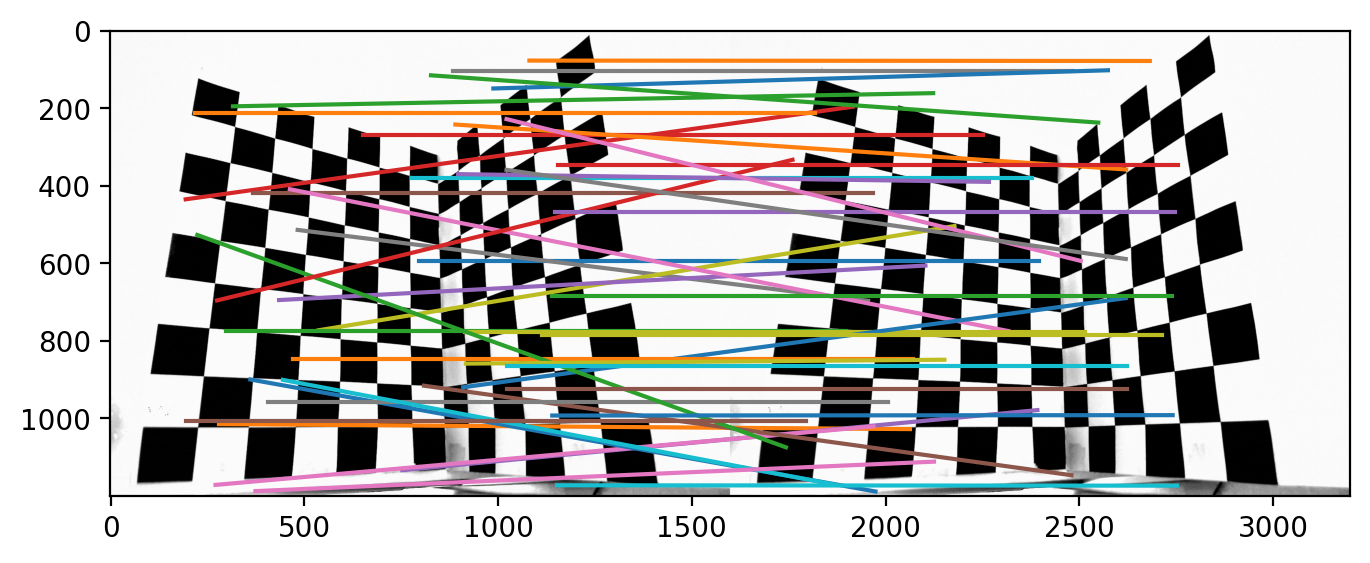

In [7]:
lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, two points x_i1, x_j2 are considered a match between
# sets 1 and 2 if x_i1 is the nearest neighbor of x_j2 and x_j2 is the
# nearest neighbor of x_i1
match_idx = 1
for i in range(l1_data.shape[0]):
  dist_1, idx_1 = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx_1[0][0]
  dist_2, idx_2 = l1_kdt.query(np.expand_dims(l2_data[j, :], axis=0), k=1)
  same_i = idx_2[0][0]
  if i == same_i:
    lines_nneigh[0, match_idx] = filtered_l1_candidates.T[i, 1]
    lines_nneigh[1, match_idx] = filtered_l1_candidates.T[i, 0]

    lines_nneigh[2, match_idx] = filtered_l2_candidates.T[j, 1]
    lines_nneigh[3, match_idx] = filtered_l2_candidates.T[j, 0]
    match_idx += 1

lines_nneigh = lines_nneigh[:, :match_idx]
plot_matches(gray, gray, lines_nneigh)

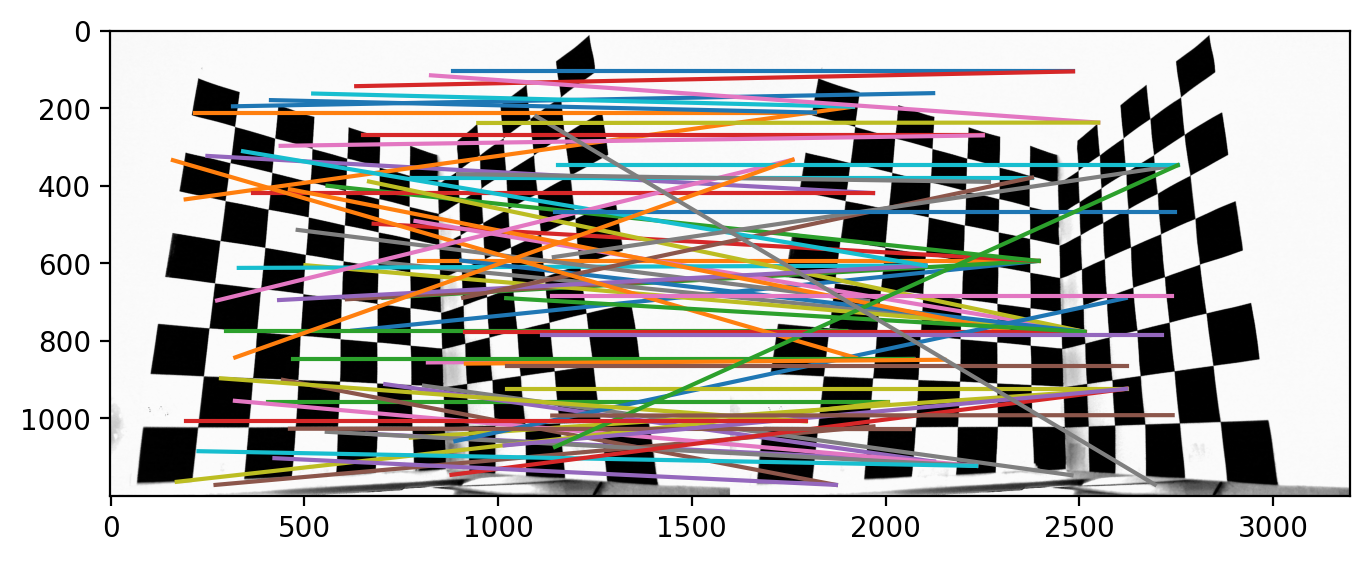

In [8]:
r = 0.2

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, two points x_i1, x_j2 are considered a match between
# sets 1 and 2 if x_i1 is the nearest neighbor of x_j2 and the second nearest
# neighbor is at a distance greater by a given ratio in [0, 1)
match_idx = 1
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=2)
  j = idx[0][0]
  if dist[0, 1]/(dist[0, 0] + 1e-15) > (1 + r):
    lines_nneigh[0, match_idx] = filtered_l1_candidates.T[i, 1]
    lines_nneigh[1, match_idx] = filtered_l1_candidates.T[i, 0]

    lines_nneigh[2, match_idx] = filtered_l2_candidates.T[j, 1]
    lines_nneigh[3, match_idx] = filtered_l2_candidates.T[j, 0]
    match_idx += 1

lines_nneigh = lines_nneigh[:, :match_idx]
plot_matches(gray, gray, lines_nneigh)


We can see that there are some differences between the features that use the more stable method and those that do not.

### 2. Use a PCA compressed version of the local patch as feature descriptor. Assess the quality of the matches when increasing the number of principal components used for the feature descriptor.

In [9]:

def feature_extractor_pca(img, point, comps):
  pca = PCA(n_components=comps)
  i, j = point.astype(np.int32)
  return pca.fit_transform(img[(i-4):(i+5), (j-4):(j+5)]).flatten()


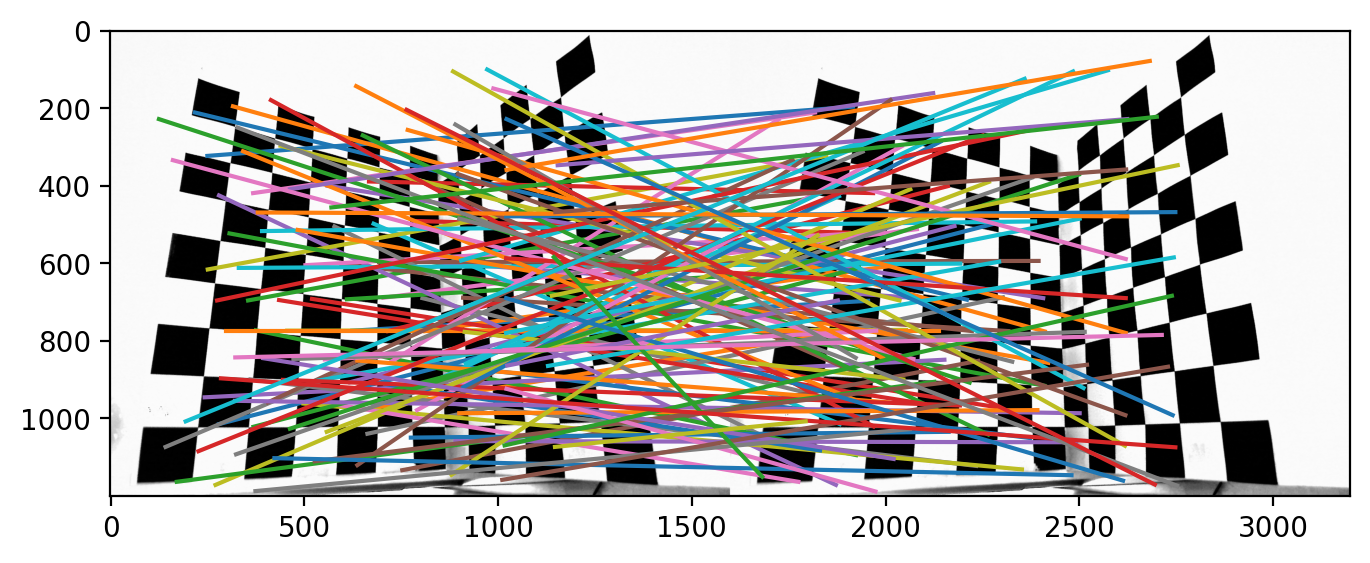

In [10]:
l1_data = np.array([feature_extractor_pca(gray, x, 2) for x in filtered_l2_candidates.T])
l2_data = np.array([feature_extractor_pca(gray, x, 2) for x in filtered_l2_candidates.T])

l1_kdt = KDTree(l1_data, leaf_size=5, metric='euclidean')
l2_kdt = KDTree(l2_data, leaf_size=5, metric='euclidean')

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, the nearest neighbor in the other set is
# considered the match
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx[0][0] #query interface limitation. Print the fn output to understand

  lines_nneigh[0, i] = filtered_l1_candidates.T[i, 1]
  lines_nneigh[1, i] = filtered_l1_candidates.T[i, 0]

  lines_nneigh[2, i] = filtered_l2_candidates.T[j, 1]
  lines_nneigh[3, i] = filtered_l2_candidates.T[j, 0]

plot_matches(gray, gray, lines_nneigh)

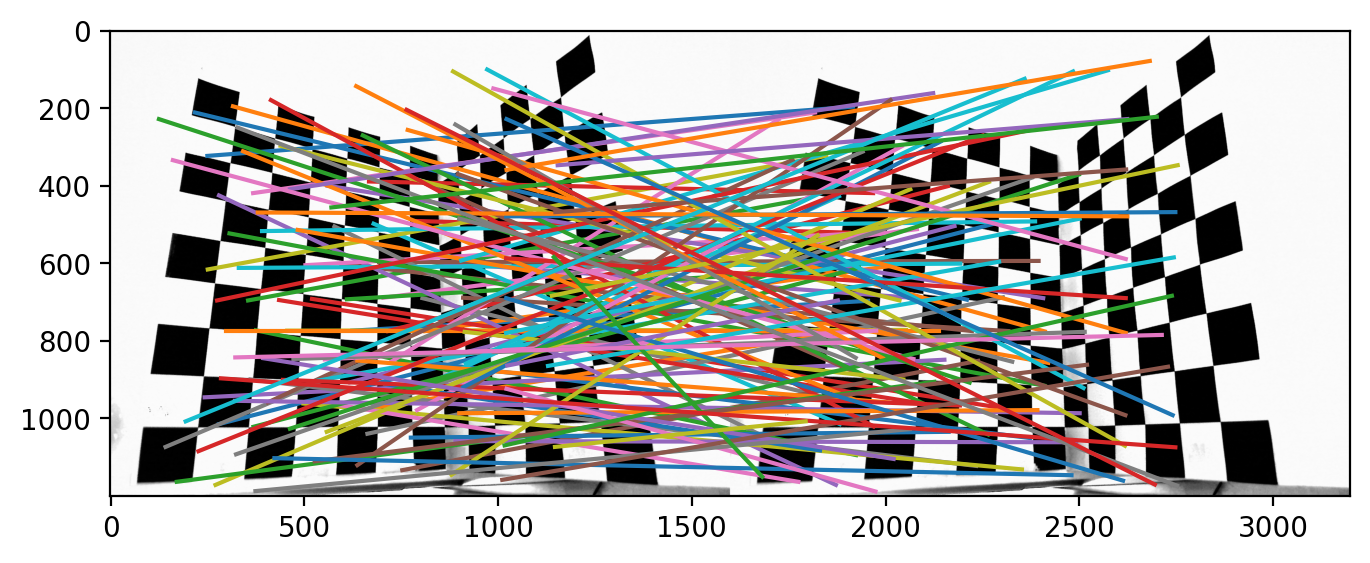

In [11]:
l1_data = np.array([feature_extractor_pca(gray, x, 5) for x in filtered_l2_candidates.T])
l2_data = np.array([feature_extractor_pca(gray, x, 5) for x in filtered_l2_candidates.T])

l1_kdt = KDTree(l1_data, leaf_size=5, metric='euclidean')
l2_kdt = KDTree(l2_data, leaf_size=5, metric='euclidean')

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, the nearest neighbor in the other set is
# considered the match
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx[0][0] #query interface limitation. Print the fn output to understand

  lines_nneigh[0, i] = filtered_l1_candidates.T[i, 1]
  lines_nneigh[1, i] = filtered_l1_candidates.T[i, 0]

  lines_nneigh[2, i] = filtered_l2_candidates.T[j, 1]
  lines_nneigh[3, i] = filtered_l2_candidates.T[j, 0]

plot_matches(gray, gray, lines_nneigh)

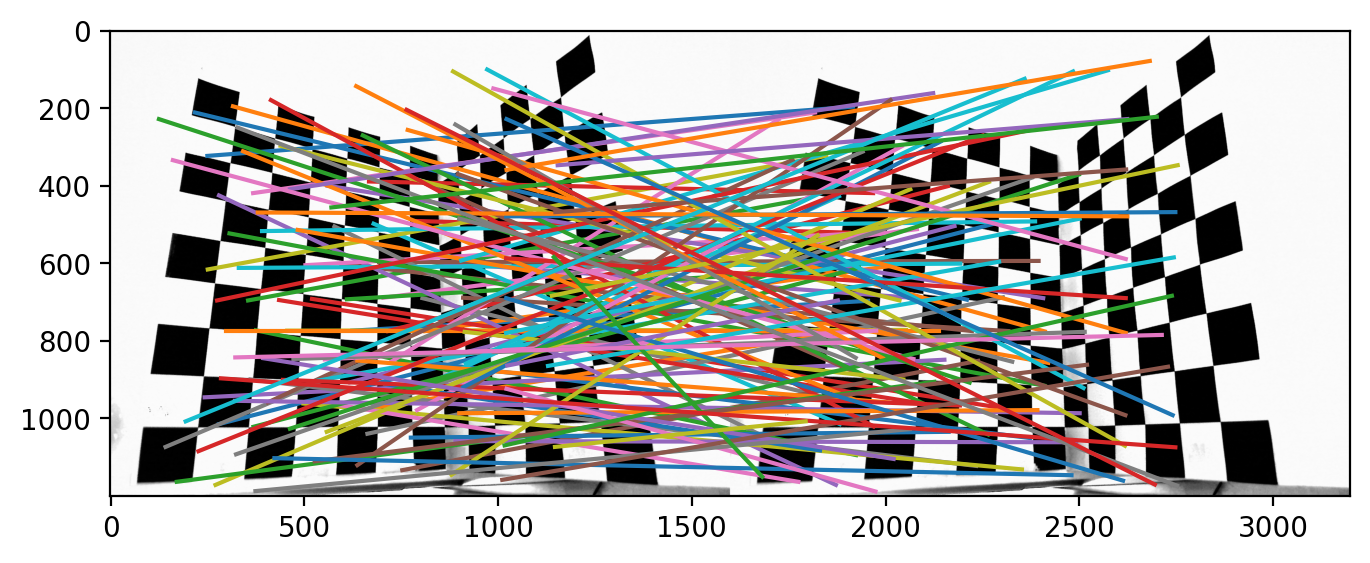

In [12]:
l1_data = np.array([feature_extractor_pca(gray, x, 7) for x in filtered_l2_candidates.T])
l2_data = np.array([feature_extractor_pca(gray, x, 7) for x in filtered_l2_candidates.T])

l1_kdt = KDTree(l1_data, leaf_size=5, metric='euclidean')
l2_kdt = KDTree(l2_data, leaf_size=5, metric='euclidean')

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, the nearest neighbor in the other set is
# considered the match
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx[0][0] #query interface limitation. Print the fn output to understand

  lines_nneigh[0, i] = filtered_l1_candidates.T[i, 1]
  lines_nneigh[1, i] = filtered_l1_candidates.T[i, 0]

  lines_nneigh[2, i] = filtered_l2_candidates.T[j, 1]
  lines_nneigh[3, i] = filtered_l2_candidates.T[j, 0]

plot_matches(gray, gray, lines_nneigh)

I do not see any visible difference when modifying the number of principal components. However, the features seem

### 3. Use the scikit pipelining method to chain different feature descriptors extractors and classifiers.

In [13]:
# Tutorial example
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from kymatio.sklearn import Scattering2D

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
pipe.score(X_test, y_test)

0.88

In [14]:
digits = load_digits()
images = digits.images

In [15]:
images = images.reshape((images.shape[0], -1))
x_train, x_test, y_train, y_test = train_test_split(images, digits.target, test_size=0.5, shuffle=True)
pipeline = Pipeline([
    ('scatter', Scattering2D(shape=(8, 8), J=1)),
    ('clf', LogisticRegression())
])

In [16]:
pipeline.fit(x_train, y_train)

c:\users\georges\documents\facultate\master\an1\s2\uaic_fii_cv\pythonproject\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scatter',
                 Scattering2D(J=1,
                              backend=<class 'kymatio.scattering2d.backend.numpy_backend.backend'>,
                              shape=(8, 8))),
                ('clf', LogisticRegression())])

[9]


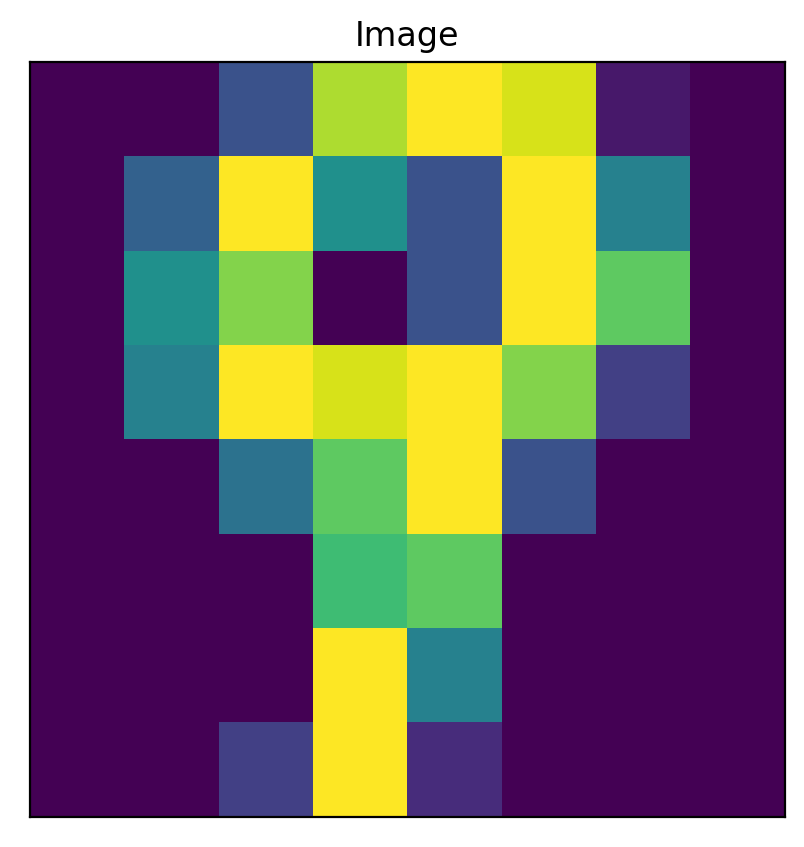

[5]


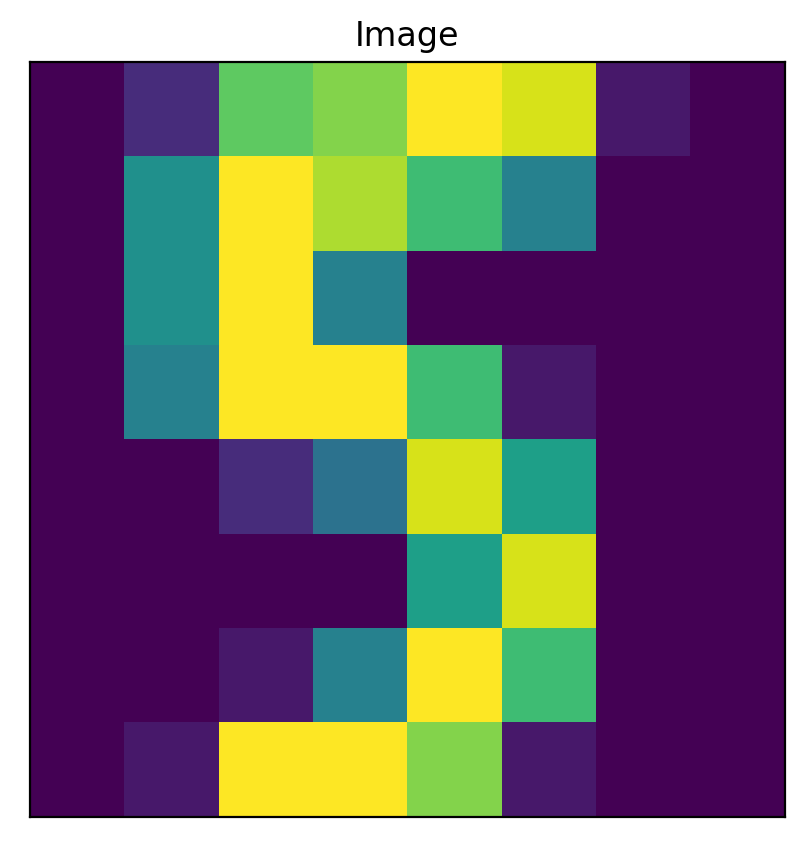

[4]


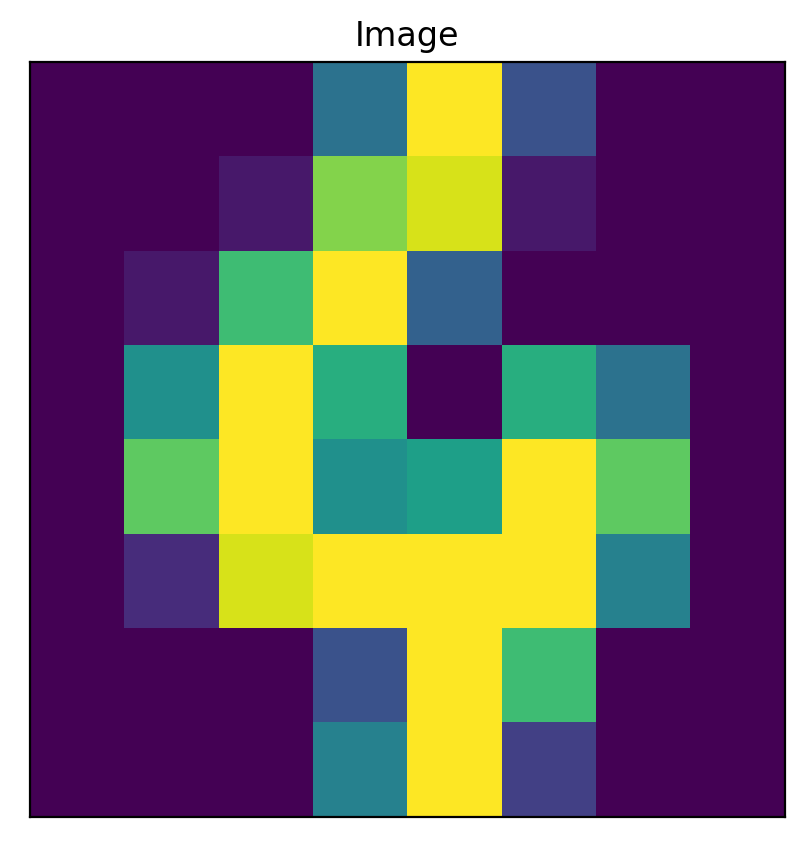

[5]


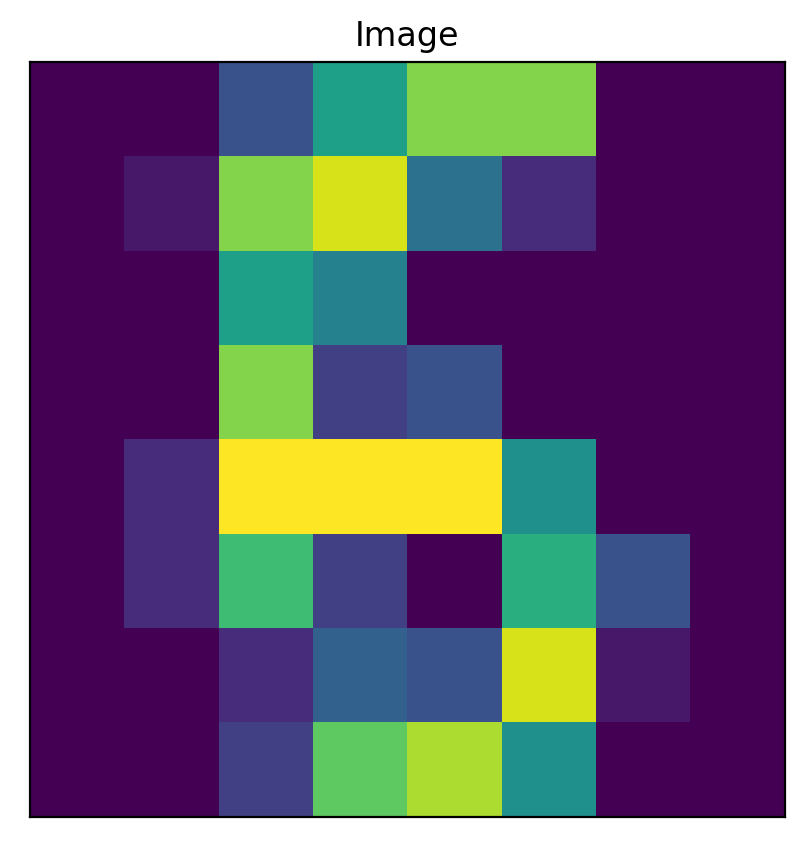

[7]


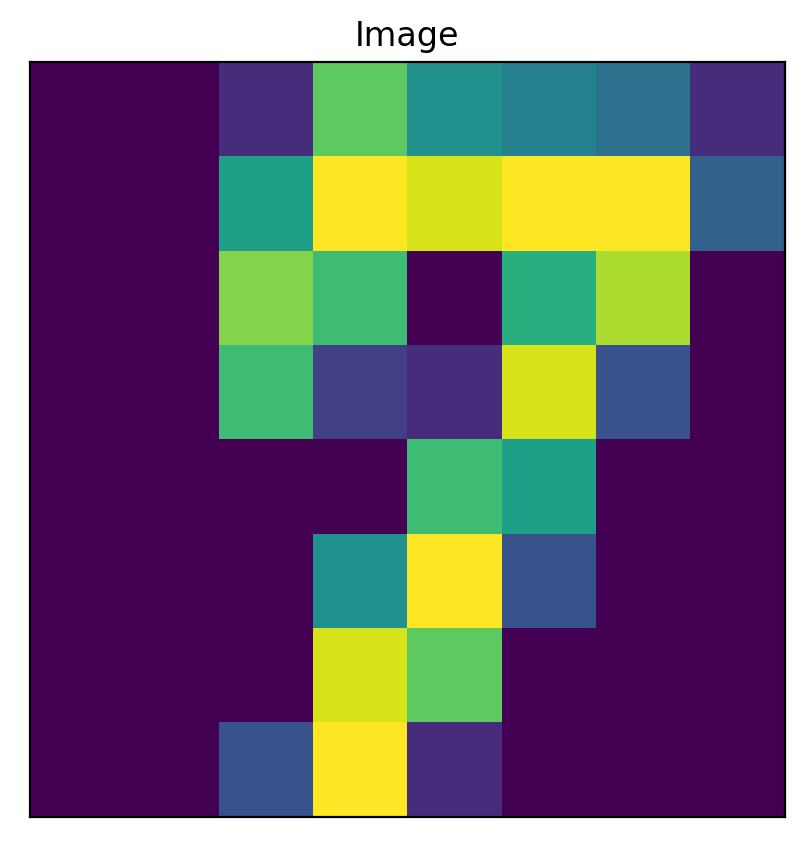

In [17]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

for i in x_test[:5]:
  img = np.reshape(i, (8, 8))
  y_pred = pipeline.predict(np.array([i]))
  print(y_pred)
  cv.putText(img, str(y_pred[0]), (10, 30), cv.FONT_HERSHEY_SIMPLEX,
                1.0, (255, 0, 0), 3)
  visualize(image=img)


### 4. Simulate image compression using different combinations of the principal components. Identify the type of information coded by each component. Implement a linear blending feature to suppress/enhance each component.


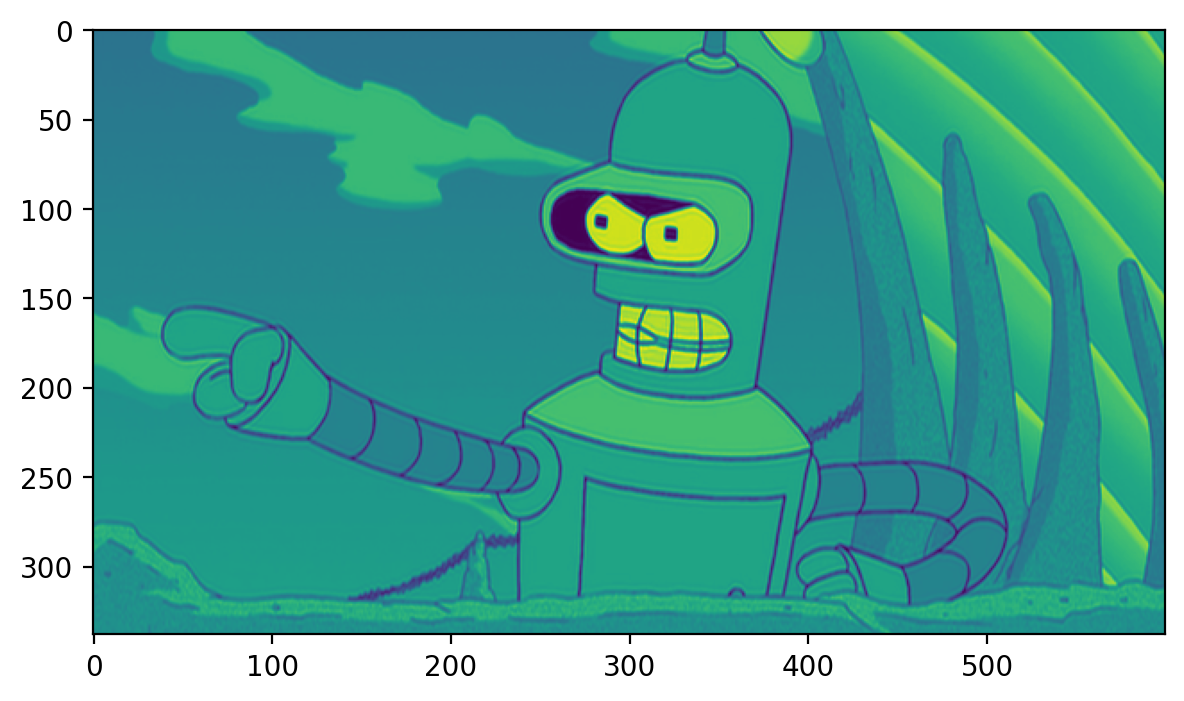

In [53]:
def get_pca_compressed(img, comps):
  pca = PCA(n_components=comps)
  return pca.inverse_transform(pca.fit_transform(img))


bender = cv.imread("bender.png")
gray_bender = cv.cvtColor(bender, cv.COLOR_BGR2GRAY)
plt.imshow(gray_bender)

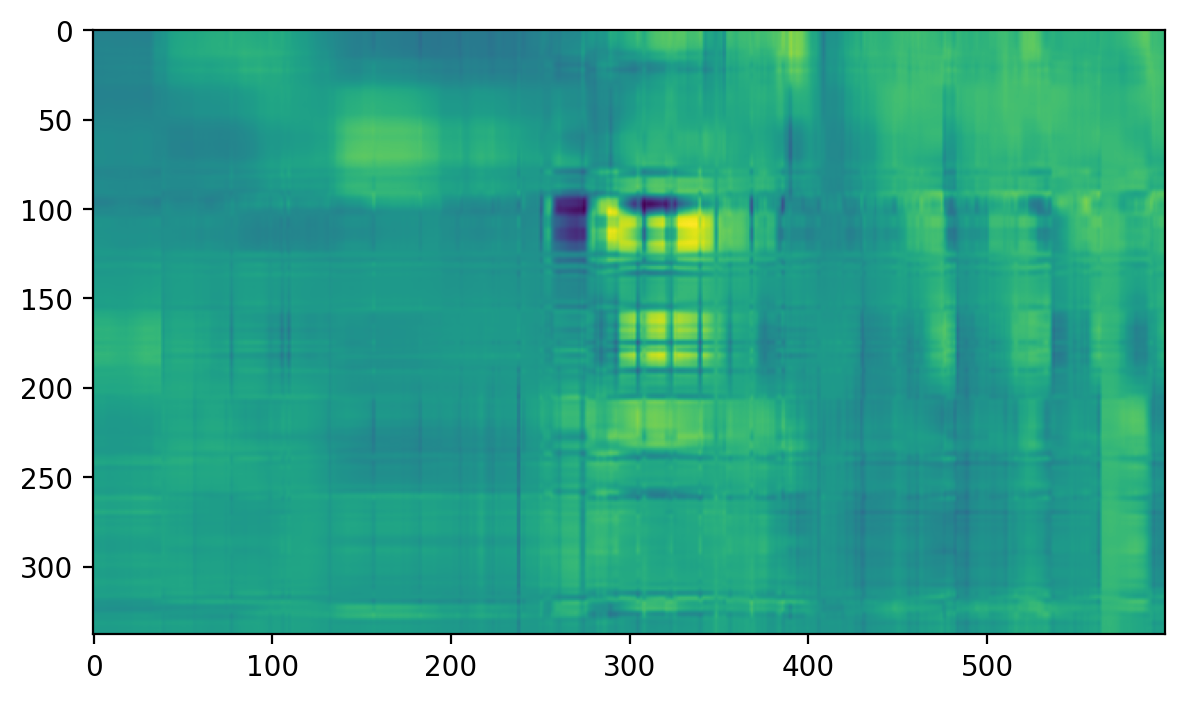

In [52]:
plt.imshow(get_pca_compressed(gray_bender, 5))

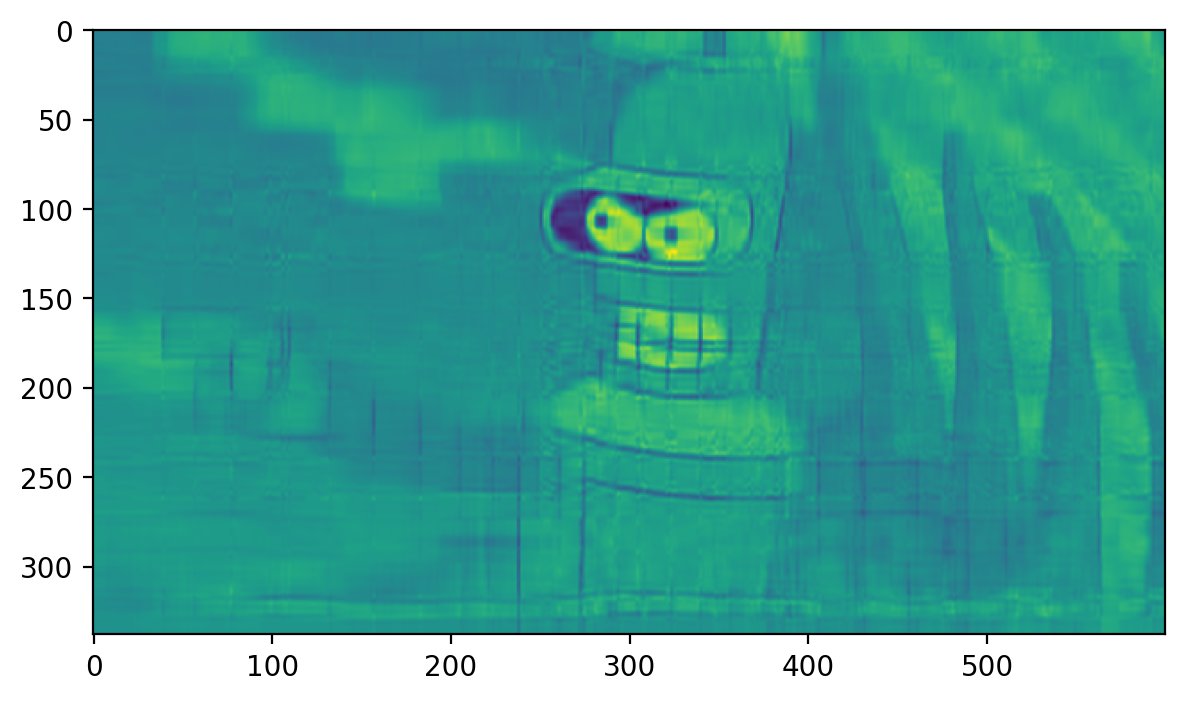

In [54]:
plt.imshow(get_pca_compressed(gray_bender, 15))

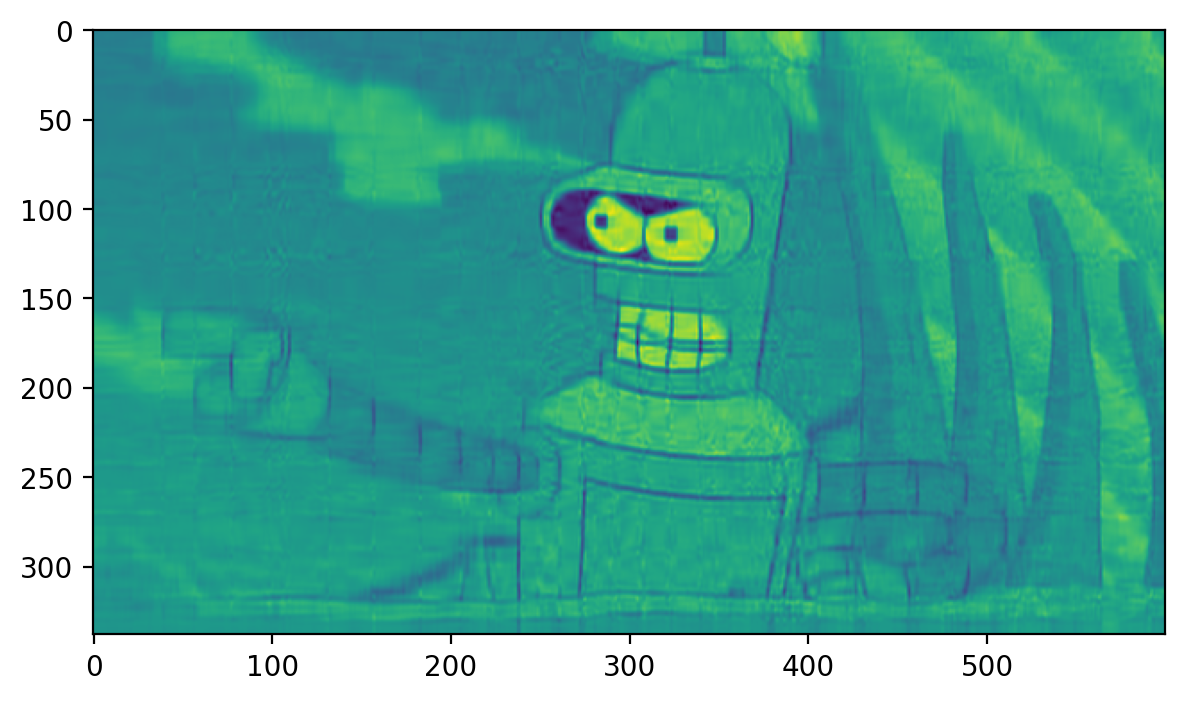

In [55]:
plt.imshow(get_pca_compressed(gray_bender, 25))

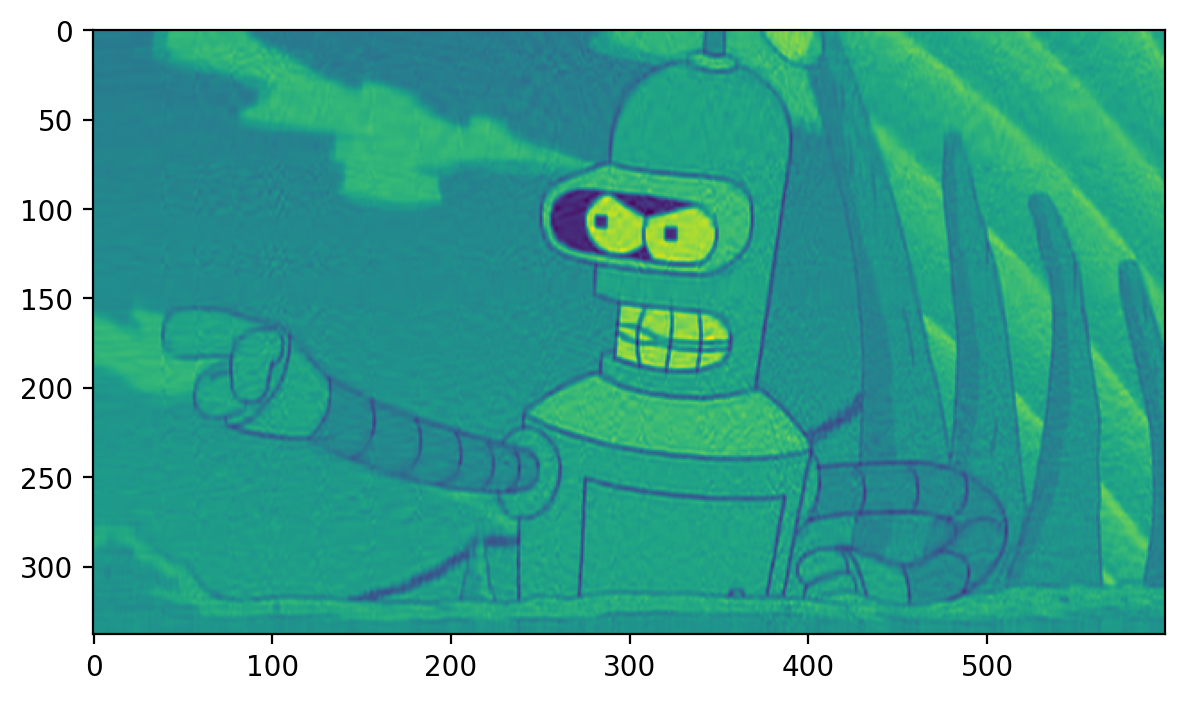

In [56]:
plt.imshow(get_pca_compressed(gray_bender, 50))